In [32]:
import numpy as np
import matplotlib.pyplot as plt

In [33]:
class PrimalDualInteriorPointSolver:
    """
    Resolve um problema de programação linear na forma padrão usando o
    Método de Pontos Interiores Primal-Dual (versão infactível).

    O problema deve estar no seguinte formato:
    minimizar   c^T * x
    sujeito a   A * x = b
                x >= 0
    """

    def __init__(self, A, b, c, alpha=0.1, beta=0.995, tol=1e-7, max_iter=100):
        """
        Inicializa o solver com os dados do problema e os parâmetros do algoritmo.
        """
        m, n = A.shape
        if b.shape[0] != m or b.ndim > 1:
            raise ValueError(f"A dimensão de 'b' ({b.shape}) é incompatível com 'A' ({A.shape}).")
        if c.shape[0] != n or c.ndim > 1:
            raise ValueError(f"A dimensão de 'c' ({c.shape}) é incompatível com 'A' ({A.shape}).")

        self.A, self.b, self.c = A, b, c
        self.m, self.n = m, n
        self.alpha, self.beta, self.tol, self.max_iter = alpha, beta, tol, max_iter
        
        # Estrutura para armazenar dados da execução para visualização
        self.statistics = {}


    @staticmethod
    def find_starting_point(A, b, c, verbose=True):
        """
        Encontra um ponto inicial (x0, lambda0, mu0) com x0 > 0 e mu0 > 0
        usando uma heurística padrão.
        """
        m, n = A.shape
        try:
            AAT_inv = np.linalg.inv(A @ A.T)
            x_hat = A.T @ AAT_inv @ b
            lambda_hat = AAT_inv @ A @ c
        except np.linalg.LinAlgError:
            if verbose:
                print("Aviso: A @ A.T é singular. Usando lstsq como fallback.")
            x_hat = np.linalg.lstsq(A, b, rcond=None)[0]
            lambda_hat = np.linalg.lstsq(A.T, c, rcond=None)[0]
        
        mu_hat = c - A.T @ lambda_hat

        delta_x = max(-1.5 * np.min(x_hat), 1e-4) if np.min(x_hat) < 0 else 1e-4
        delta_mu = max(-1.5 * np.min(mu_hat), 1e-4) if np.min(mu_hat) < 0 else 1e-4
        
        x0 = x_hat + delta_x
        mu0 = mu_hat + delta_mu
        lambda0 = lambda_hat
        
        if verbose:
            print("--- Ponto Inicial Heurístico Encontrado ---")
            print(f"  Norma de x0: {np.linalg.norm(x0):.4f}, Mín(x0): {np.min(x0):.4f}")
            print(f"  Norma de μ0: {np.linalg.norm(mu0):.4f}, Mín(μ0): {np.min(mu0):.4f}")

        return x0, lambda0, mu0

    def solve(self, x0, lambda0, mu0, verbose=True):
        """
        Executa o algoritmo Primal-Dual a partir de um ponto inicial.
        """
        if verbose:
            print("\n--- Iniciando o Método de Pontos Interiores Primal-Dual ---")
        
        # Reinicia o histórico de caminho para a visualização
        self.statistics['path'] = [x0[:2].copy()] # Armazena apenas (x1, x2)

        k = 0
        x, lam, mu = x0.copy(), lambda0.copy(), mu0.copy()

        while k < self.max_iter:
            if verbose:
                print(f"\n--- Iteração {k} ---")

            rp = self.b - self.A @ x
            rd = self.c - self.A.T @ lam - mu
            gap = x.T @ mu
            
            if verbose:
                print(f"  Gap de Dualidade (x^T * mu): {gap:.6e}")
                print(f"  Norma do Resíduo Primal ||b-Ax||: {np.linalg.norm(rp):.6e}")
                print(f"  Norma do Resíduo Dual ||c-A^Tλ-μ||: {np.linalg.norm(rd):.6e}")

            if np.linalg.norm(rp) < self.tol and np.linalg.norm(rd) < self.tol and gap < self.tol:
                if verbose:
                    print(f"\nSolução ótima encontrada em {k} iterações.")
                return x, lam, mu, k

            delta = self.alpha * (gap / self.n)
            
            if verbose:
                print(f"  Parâmetro de Centralização (δ): {delta:.6e}")

            dx, dlam, dmu = self._solve_newton_system(x, mu, rp, rd, delta, verbose)
            theta = self._calculate_step_size(x, mu, dx, dmu)

            if verbose:
                print(f"  Tamanho do Passo (θ): {theta:.4f}")

            x += theta * dx
            lam += theta * dlam
            mu += theta * dmu
            
            # Armazena o ponto atual no histórico
            self.statistics['path'].append(x[:2].copy())
            k += 1

        if verbose:
            print("\nNúmero máximo de iterações atingido.")
        return x, lam, mu, k

    def _solve_newton_system(self, x, mu, rp, rd, delta, verbose=True):
        rc = delta - x * mu
        theta_inv_diag = mu / (x + 1e-25)
        
        lhs_lambda = self.A @ (self.A.T.T * (1 / (theta_inv_diag + 1e-25))).T
        rhs_lambda = rp + self.A @ ((rd - rc / (x + 1e-25)) / (theta_inv_diag + 1e-25))
        
        try:
            dlam = np.linalg.solve(lhs_lambda, rhs_lambda)
        except np.linalg.LinAlgError:
            if verbose:
                print("Aviso: Sistema singular para Δλ. Usando lstsq como fallback.")
            dlam = np.linalg.lstsq(lhs_lambda, rhs_lambda, rcond=None)[0]

        dmu = rd - self.A.T @ dlam
        dx = (rc - x * dmu) / (mu + 1e-25)
        return dx, dlam, dmu

    def _calculate_step_size(self, x, mu, dx, dmu):
        alpha_p = 1.0
        for i in range(self.n):
            if dx[i] < -1e-12:
                alpha_p = min(alpha_p, -x[i] / dx[i])
        
        alpha_d = 1.0
        for i in range(self.n):
            if dmu[i] < -1e-12:
                alpha_d = min(alpha_d, -mu[i] / dmu[i])
        
        return self.beta * min(alpha_p, alpha_d)
    
    def calculate_central_path(self, num_points=50, initial_gap=10):
        """
        Calcula uma aproximação do caminho central teórico.
        """
        path_points = []
        x, lam, mu = self.find_starting_point(self.A, self.b, self.c, verbose=False)
        
        # Cria uma sequência de valores para o parâmetro de barreira/centralização
        deltas = np.logspace(np.log10(initial_gap), np.log10(self.tol * 10), num_points)

        for delta in deltas:
            # Para cada 'delta', executa algumas iterações de Newton para convergir 
            # para o ponto correspondente no caminho central
            for _ in range(15): # Máximo de 15 iterações internas
                rp = self.b - self.A @ x
                rd = self.c - self.A.T @ lam - mu
                
                # Resolve o sistema de Newton para a direção
                dx, dlam, dmu = self._solve_newton_system(x, mu, rp, rd, delta, verbose=False)
                
                # Usa um passo completo para convergir rapidamente ao caminho
                theta = self._calculate_step_size(x, mu, dx, dmu)
                
                x += theta * dx
                lam += theta * dlam
                mu += theta * dmu
                
                # Condição de parada para a convergência a este ponto do caminho
                if np.linalg.norm(rp) < self.tol * 10 and np.linalg.norm(rd) < self.tol * 10:
                    break
            
            path_points.append(x[:2].copy())
            
        self.statistics['central_path'] = path_points
        return np.array(path_points)

In [34]:
def plot_results(solver, b_orig, central_path_points=None):
    """
    Plota a região factível, o caminho do solver e o caminho central teórico.
    """
    path = np.array(solver.statistics['path'])
    
    fig, ax = plt.subplots(figsize=(12, 9))
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.6)

    x_max = max(path[:, 0].max(), b_orig.max()) + 1
    y_max = max(path[:, 1].max(), b_orig.max()) + 1
    ax.set_xlim(-1, x_max)
    ax.set_ylim(-1, y_max)
    
    x_vals = np.linspace(-1, x_max, 400)
    y1, y2, y3 = 6 - x_vals, x_vals - 4, x_vals + 4
    
    ax.plot(x_vals, y1, label='x₁ + x₂ = 6', color='gray', alpha=0.7)
    ax.plot(x_vals, y2, label='x₁ - x₂ = 4', color='gray', alpha=0.7)
    ax.plot(x_vals, y3, label='-x₁ + x₂ = 4', color='gray', alpha=0.7)

    y_lower = np.maximum(0, y2)
    y_upper = np.minimum(y1, y3)
    ax.fill_between(x_vals, y_lower, y_upper, where=y_upper>y_lower, color='cyan', alpha=0.3, interpolate=True, label='Região Factível')
    
    if central_path_points is not None:
        ax.plot(central_path_points[:, 0], central_path_points[:, 1], 'k--', linewidth=2, label='Caminho Central (Teórico)')

    ax.plot(path[:, 0], path[:, 1], 'o-', color='orange', markersize=5, linewidth=2, label='Caminho do Solver')
    ax.plot(path[0, 0], path[0, 1], 'go', markersize=10, label='Ponto Inicial')
    ax.plot(path[-1, 0], path[-1, 1], 'r*', markersize=15, label='Ponto Ótimo')
    
    ax.set_xlabel("x₁", fontsize=14)
    ax.set_ylabel("x₂", fontsize=14)
    ax.set_title("Caminho do Método de Pontos Interiores vs. Caminho Central", fontsize=16)
    ax.legend(loc='upper left')
    plt.show()

In [35]:
# --- Definição do Problema Original ---
# min -x1 -2x2
# s.t.
#   x1 + x2 <= 6
#   x1 - x2 <= 4
#  -x1 + x2 <= 4
#   x1, x2 >= 0
A_orig = np.array([[1,1], [1,-1], [-1,1]])
b_orig = np.array([6, 4, 4])

# --- Conversão para a Forma Padrão ---
A = np.array([[1, 1, 1, 0, 0], [1, -1, 0, 1, 0], [-1, 1, 0, 0, 1]])
b = np.array([6, 4, 4])
c = np.array([-1, -2, 0, 0, 0])

# 1. Instancia o solver
solver = PrimalDualInteriorPointSolver(A, b, c, tol=1e-8)

# 2. Encontra um ponto inicial
x0, lambda0, mu0 = solver.find_starting_point(A, b, c, verbose=False)

# 3. Resolve o problema
x_opt, _, _, iters = solver.solve(x0, lambda0, mu0, verbose=False)


               RESULTADO FINAL
Solução ótima encontrada em 10 iterações.

Variáveis de decisão:
  x1 = 1.0
  x2 = 5.0

Valor da função objetivo: -11.000000


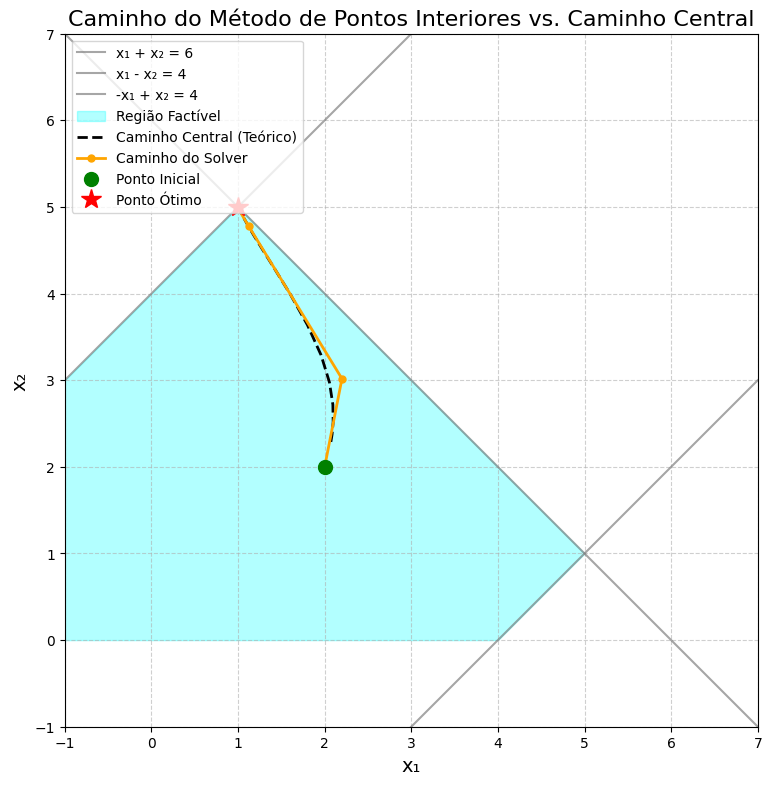

In [36]:
# 4. Exibe os resultados finais
print("\n" + "="*50)
print("               RESULTADO FINAL")
print("="*50)
print(f"Solução ótima encontrada em {iters} iterações.")
x_opt_rounded = np.round(x_opt, 6)
print("\nVariáveis de decisão:")
print(f"  x1 = {x_opt_rounded[0]}")
print(f"  x2 = {x_opt_rounded[1]}")
obj_value = c @ x_opt
print(f"\nValor da função objetivo: {obj_value:.6f}")
print("="*50)

# 5. Plota o gráfico dos resultados
central_path = solver.calculate_central_path()
plot_results(solver, b_orig, central_path)